## 支持向量机(support vector machines)
#### 支持向量机(SVM)是一个非常强大并且用多种功能的机器学习模型，能够做线性或者非线性的分类，回归，甚至是异常值检测。SVM特别适合应用于复杂但中小规模数据集的分类问题

### 1.线性支持向量机分类
#### 概念：
* 最大间隔分类
* 支持向量
* 对特征缩放很敏感，可以使用StandardScaler()进行特征缩放

### 1.1 软间隔分类
#### 硬间隔分类：严格规定所有的数据都不在“街道”上，都在正确的两边
* 只对线性可分的数据起作用
* 对异常点敏感

#### 软间隔分类：保持“街道”尽可能大和避免间隔违规（数据点出现在“街道”中央或者甚至在错误的一边）之间找到一个良好的平衡
#### Scikit-Learn库的SVM类，使用C超参数(惩罚系数)来控制这种平衡：较小的C会导致更宽的“街道”，但更多的间隔违规
* 较大的C值，导致更少的间隔违规，但是间隔较小
* 较小的C值，导致更多的间隔违规，但是间隔更大，泛化的更好
* 如果SVM模型过拟合，可以尝试减少超参数C调整

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:,(2, 3)]  # 花瓣长度和宽度
y = (iris['target'] == 2).astype(np.float64)  # Iris-Virginica类别

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

### 1.2 注意：
* 不同于Logistic回归分类器，SVM分类器不会输出每个类别的概率（AttributeError: 'LinearSVC' object has no attribute 'predict_proba'）
* LinearSVC要使偏置项规范化：
    * 首先，集中训练集减去它的平均数，使用StandarScaler会自动处理
    * 其次，确保loss参数为hinge，因为它不是默认值
    * 最后，dual参数设置为False，除非特征数比样本数多

* 可以使用SVC类，即SVC(kernel='linear', C=1)，但是速度很慢，一般不推荐
* 可以使用SGDClassifier类，即SGDClassifier(loss='hinge', alpha=1/(m* C))，应用随机梯度下降来训练一个线性SVM分类器


### 2.非线性支持向量机分类
#### 尽管线性SVM分类器在许多案例上表现的出乎意料的好，但是很多数据集并不是线性可分的。
#### 处理非线性数据集的方法：
* 增加更多的特征，例如：多项式特征
* 在某些情况下可以变成线性可分的数据

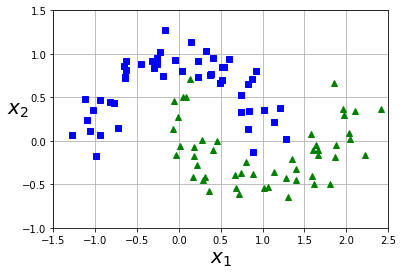

In [3]:
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

X, y = datasets.make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel('$x_1$', fontsize=20)
    plt.ylabel('$x_2$', fontsize=20, rotation=0)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [4]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),  # 有了degre才是多项式特征将非线性变为线性
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

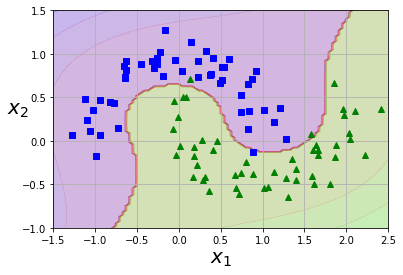

In [5]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # 等高线
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

### 2.1 多项式核
#### 添加多项式特征很容易实现，在各种机器学习算法都有不错的表现，但是：
* 低次数的多项式不能处理非常复杂的数据
* 高次数的多项式产生大量的特征，会使模型变得缓慢

#### 使用SVM时，可以使用“**核技巧**”(kernel trick)的神奇数学技巧，它可以取得像添加了许多多项式，甚至有高次数的多项式一样好的结果。所以不会大量特征导致的组合爆炸，因为没有增加任何特征

In [6]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

poly10_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])

poly10_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Text(0.5,1,'$d=10, r=100, C=5$')

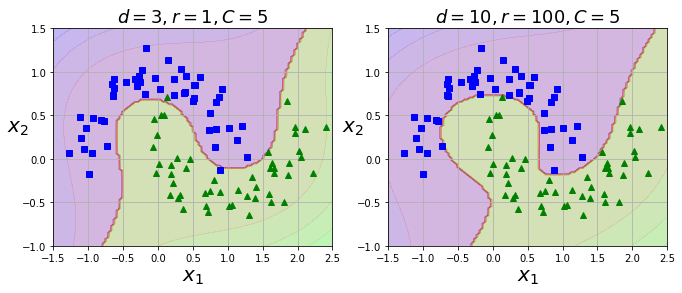

In [7]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly10_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

* 左图使用3阶的多项式核训练，右图使用10阶的多项式核训练
* 如果模型过拟合，减少多项式核的阶数
* 如果模型欠拟合，尝试增大阶数
* 超参数coef0控制高阶多项式与低阶多项式对模型的影响

### 2.2 增加相似特征
#### 另一个解决非线性问题的方法是使用相似函数(similarity function)，计算每个样本与特定地标(landmark)的相似度

#### 高斯径向基函数(Gaussian Radial Basis Function,RBF):
$\phi_\gamma(x, l)\ =\ exp(-\gamma\parallel x-l\parallel^2)$
#### 它是一个从0到1的钟型函数，值为0的离地表很远，值为1的在地标上

[-4.5, 4.5, -0.1, 1.1]

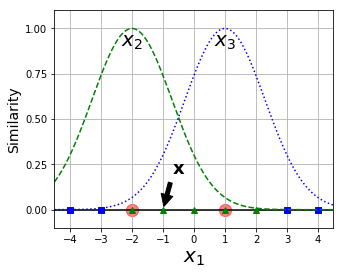

In [8]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)  # （-1， 1）不管多少行，把数据变成一列
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)  # [[-4],[-3],[-2],[-1],[0],[1],[2],[3],[4]]
X2D = np.c_[X1D, X1D**2]

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')  #  horizontal line画水平线
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',  # 注释文本，加黑小写字母
             xy=(X1D[3, 0], 0),  # xy是被注释的坐标点
             xytext=(-0.5, 0.20),  # 注释文字的坐标位置
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),  # 箭头参数（箭头颜色和总长度）
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)  # 在任意位置添加文字
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])



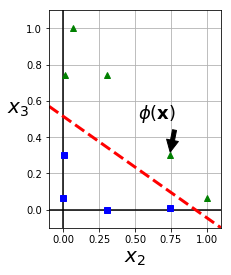

In [9]:
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

#### 显示了特征转换后的数据集(删除了原始特征)
#### 确定地标的方法：
* 在数据集的每一个样本的位置创建地标
* 产生更多的维度从而增加了转换后数据集是线性可分的可能性
* 但是m个样本，n个特征的数据集被转换成了m个实例，m个特征的训练集，导致如果训练集非常大则得到同样大的特征

### 2.3 高斯RBF核
#### 相似特征法对各种机器学习算法同样有不错的表现，但是额外特征上的计算成本可能很高，特别是大规模的训练集上
#### 但是高斯核可以获得同样好的结果称为可能

Text(0.5,1,'$\\gamma=5, C=1000$')

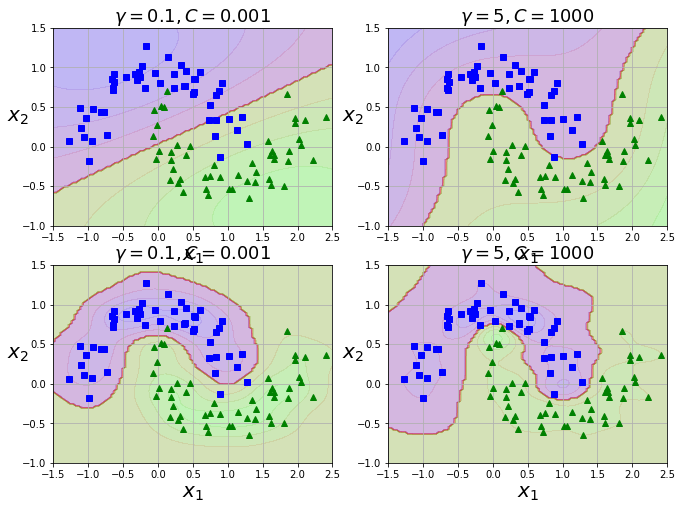

In [12]:
rbf_kernel_svm_clf1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=0.001))
])
rbf_kernel_svm_clf1.fit(X, y)

rbf_kernel_svm_clf2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=1000))
])
rbf_kernel_svm_clf2.fit(X, y)

rbf_kernel_svm_clf3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf3.fit(X, y)

rbf_kernel_svm_clf4 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=1000))
])
rbf_kernel_svm_clf4.fit(X, y)

fig = plt.figure(figsize=(11, 8))
plt.subplot(221)
plot_predictions(rbf_kernel_svm_clf1, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$\gamma=0.1, C=0.001$", fontsize=18)

plt.subplot(222)
plot_predictions(rbf_kernel_svm_clf2, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$\gamma=5, C=1000$", fontsize=18)

plt.subplot(223)
plot_predictions(rbf_kernel_svm_clf3, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$\gamma=0.1, C=0.001$", fontsize=18)

plt.subplot(224)
plot_predictions(rbf_kernel_svm_clf4, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$\gamma=5, C=1000$", fontsize=18)

#### 分析图：
* 增大$\gamma$使钟型曲线更窄，导致每个样本的影响范围变得更小：即判定边界最终变得更不规则，在单个样本周围环绕
* 减小$\gamma$使钟型曲线更宽，样本有更大的影响范围，判定边界最终则更加平滑
* 总结：模型过拟合则减小$\gamma$值，模型欠拟合则增大$\gamma$值

#### 如何选择核函数：
* 首先尝试线性核函数(LinearSVC比SVC(kernel='linear')要快得多)
* 训练集不大的情况下尝试RBF，在大多数情况下都有效
* 还可以用交叉验证和网格搜索来试验其他的核函数

### 2.4 计算复杂性
* LinearSVC是基于liblinear库，实现了线性SVM的优化算法，不支持核技巧，样本和特征的数量几乎是线性的：训练时间复杂度大约为$O(m \ x\ n)$
* SVC类基于libsvm库，它实现了支持核技巧的算法，训练时间复杂度通常介于$O(m^2 \ x\ n)$和$O(m^3\ x\ n)$之间
    * 训练样本很大时，变得及其慢
    * 对于复杂度小型或中等数量的数据集表现是完美的
    * 可以对特征进行缩放，尤其是稀疏特征（算法对样本的非零特征的平均数量进行大概的缩放）

#### <center>Table：Comparison of Scikit-Learn classes for SVM Classification(支持向量机分类)

|Class|Time Complexity|Out-of-core support|Scaling required|Kernel trick|
|-------:|:---  - - --------|----------------|-------------------------|-------|
|LinearSVC|O(m x n)|No|Yes|No|
|SGDClassifier|O(m x n)|Yes|Yes|No|
|SVC|O($m^2$ x n) to O($m^3$x n)|No|Yes|Yes|

### 支持向量机在分类任务上是使用方法
### $LinearSVC(C= \ , loss \ = \ 'hinge')$
### $SVC(kernel \ = \ 'linear')$
### $SVC(kernel = \ 'poly',\ degree=\ ,\ coef0= ,\ C=\ )$
### $SVC(kernel= \ 'rbf',\ gamma=\ ,\ C=\ )$
### 支持向量机的不同使用方法，注意里面的超参数设定

### 二、SVM回归
#### SVM算法应用广泛：
* 不仅支持线性和非线性的分类任务
* 还支持线性和非线性的回归任务

#### SVM回归任务是在限制间隔违规的情况下，尽量放置更多的样本在“街道”上，"街道"的宽度由超参数$\epsilon$

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)  # 50行1列
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()  # 1行50列

In [3]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)  # epsilon控制街道宽度
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):  
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)  # [False, False, ...]返回预测值与真实值差的绝对值大于等于街道间隔的判断
    return np.argwhere(off_margin)  # 返回元素为True的索引

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

In [4]:
svm_reg1.support_

array([[ 7],
       [14],
       [25],
       [31],
       [33],
       [34],
       [39],
       [42]], dtype=int64)

Text(0.5,1,'$\\epsilon = 0.5$')

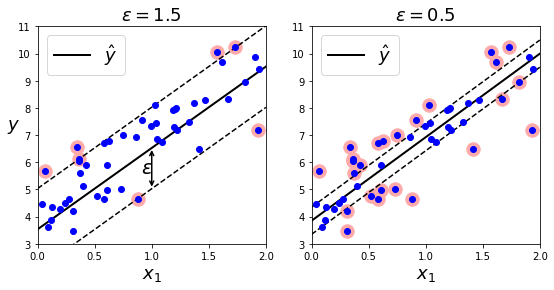

In [5]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")  # 画中间三条线
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA') # 画超过街道的点
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)
    
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)


#### 可以使用LinearSVR类实现线性SVM回归，训练数据需要被中心化和标准化

In [6]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

#### 处理非线性回归任务，可以使用核化的SVM模型

In [7]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()  # 构造非线性的训练数据

In [8]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [9]:
svm_poly_reg1 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1)

svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Text(0.5,1,'$degree=2,C=0.01,\\epsilon=0.1$')

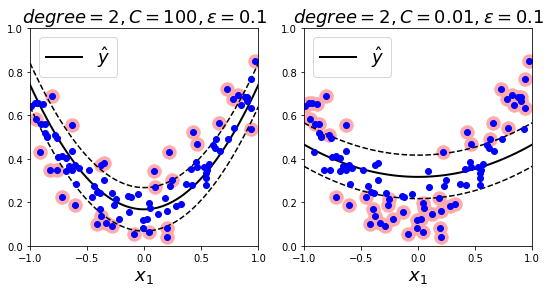

In [10]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title('$degree=2,C=100,\epsilon=0.1$', fontsize=18)

plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title('$degree=2,C=0.01,\epsilon=0.1$', fontsize=18)

#### 左图是较小的正则化（即更大的C值），右图是更大的正则化（即更小的C值）